# Argosim tutorial - Part 3

In this tutorial we will explore the `imaging_utils` module. This module provides functions to simulate radio images.

In [1]:
# Import the imaging module
from argosim.imaging_utils import *

## Sky and UV spaces


What is the link between the sky space and the uv space?
- Fourrier Transform

- In radio interferometry, observations of the sky are not directly obtained as images. Instead, interferometers measure visibilities, which are samples of the Fourier transform of the sky image in the UV plane (spatial frequency domain).

Sky space (image plane): Represents the intensity of the radio signal as a function of angular position in the sky.

UV space (spatial frequency plane): Represents the visibilities, which are the Fourier coefficients of the sky image.
 

Which functions of the `imaging_utils` module are used to convert between the sky and uv spaces? How do the work internally?

- sky2uv(sky)


### Loading a sky image
We will use `PIL.Image` to load the `png` images and `numpy` to convert the image to a numpy array. 

P.S. The `PIL` library is not installed in the Argosim environment. You can install it by running the following command:
```bash
!pip install pillow
```

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Load the Cygnus A image
sky_model_path = '../data/sky_models/cygnus_a.png'
sky_png = Image.open(sky_model_path)

# Convert the image to a numpy array
sky = np.array(sky_png)

# Check the array shape
print(sky.shape)


(541, 541, 2)


Does it have the shape we expect? no there is 2 channels

What do you have to say about the size of the image? (Hint: remember what the functions sky2uv and uv2sky do.)

it suggests that the image have two channels, instead of one. howeever, Argosim expects a 2D image (single channel).To fix this, we need to extract only one channel from the image.


(541, 541)


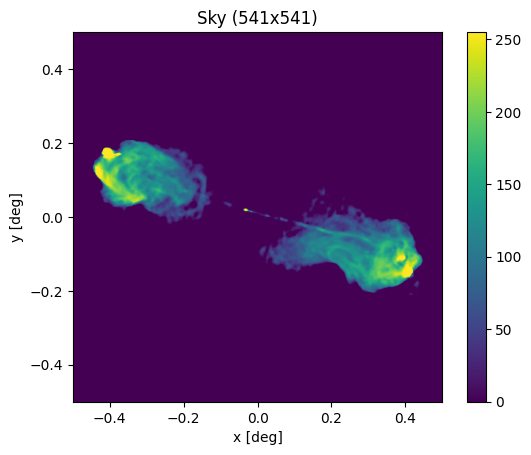

In [4]:
from argosim import plot_utils

# Argosim works with 2D images, with just one channel. Get rid of the unnecessary dimensions.

sky = sky[:, :, 0] 

# Check the new shape
print(sky.shape)  

# Plot the sky image
plot_utils.plot_sky(sky, fov_size=(1.0, 1.0), ax=None, fig=None, title='Sky')




### UV space

In [5]:
# Convert the sky model to uv space and analyze the result

from argosim.imaging_utils import sky2uv

# Convert the sky model to UV space
sky_uv = sky2uv(sky)

# Check the size and data type
print(sky_uv.shape, sky_uv.dtype)


(541, 541) complex128


What is the size of the output array? Which type of data does it contain?
...

- the size of the output array should be the same than the inputs so : (541, 541) 

- the array contains complex values, representing the amplitude and phase of spatial frequencies in the UV plane


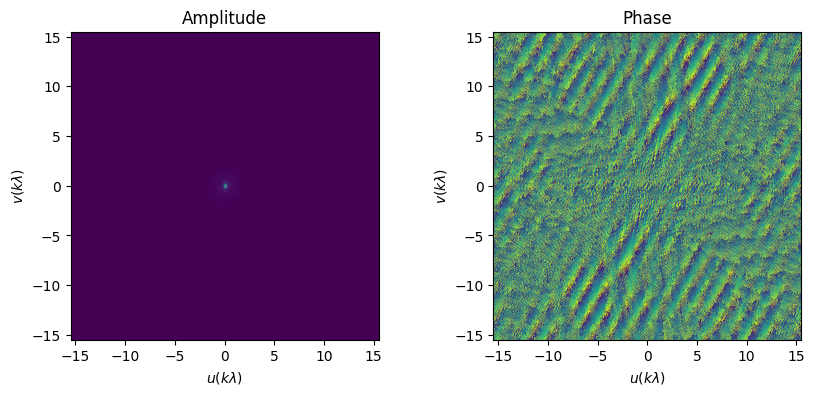

In [6]:
# Plot the sky model in uv space
plot_utils.plot_sky_uv(sky_uv, fov_size=(1.0, 1.0))




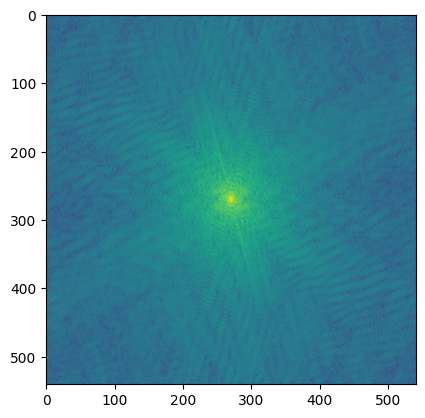

In [7]:
plt.imshow(np.log(np.abs(sky_uv)))


### Repeat for the other sky models

(512, 512)
(512, 512) complex128


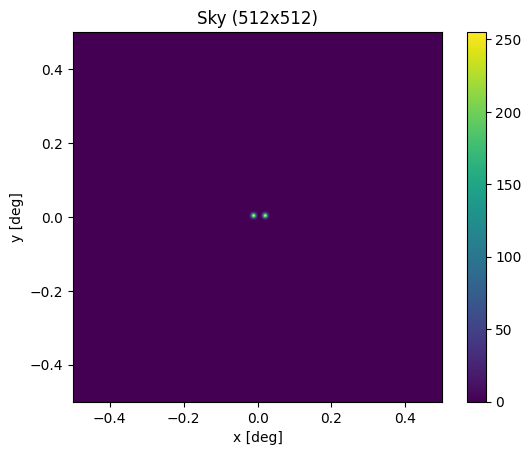

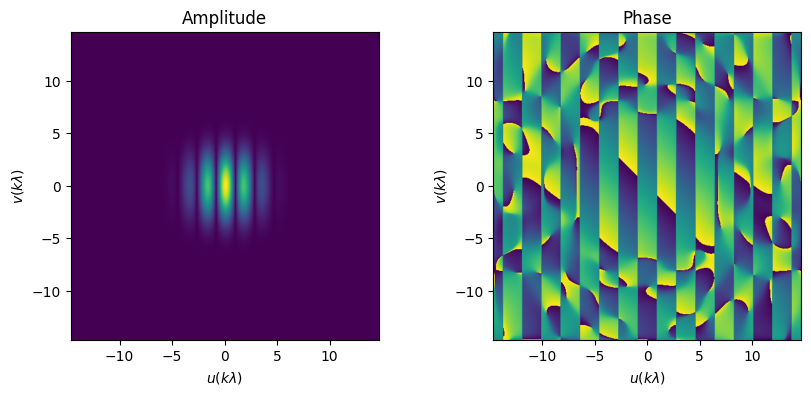

In [8]:
# Import other sky model

sky_model_path = '../data/sky_models/double_narrow.png'
sky_png = Image.open(sky_model_path)

# Convert the image to a numpy array
sky = np.array(sky_png)

# Check the array shape
print(sky.shape)

#plot sky model
plot_utils.plot_sky(sky, fov_size=(1.0, 1.0), ax=None, fig=None, title='Sky')

# Convert the sky model to UV space
sky_uv = sky2uv(sky)

# Check the size and data type
print(sky_uv.shape, sky_uv.dtype)

# Plot the sky model in uv space
plot_utils.plot_sky_uv(sky_uv, fov_size=(1.0, 1.0))



## Imaging


Recall the imaging process. What are the steps involved? How do we simulate the observed sky model given the uv coverage (uv sampling points)?

...

In [25]:
from argosim.antenna_utils import *
from argosim import antenna_utils, plot_utils
from argosim import imaging_utils

In [26]:
# Load the data
dataset = np.load('../data/sky_models/galsim_sky.npy', allow_pickle=True)[()]

# Check dataset keys
print(dataset.keys())  # Should print: dict_keys(['image', 'field_area_arcmin2'])

# Get the sky model image
sky = dataset['image']

# Compute field of view size (convert arcmin² to degrees)
fov_size = np.sqrt(dataset['field_area_arcmin2']) / 60.0



dict_keys(['image', 'gal_pos', 'star_pos', 'g1', 'g2', 'star_g1', 'star_g2', 'star_flux', 'n_galaxies', 'n_stars', 'field_area_arcmin2'])


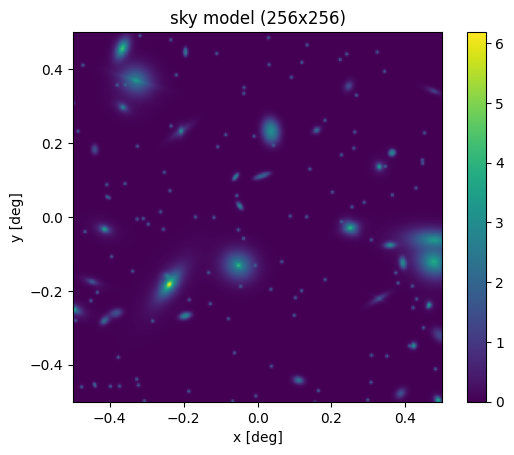

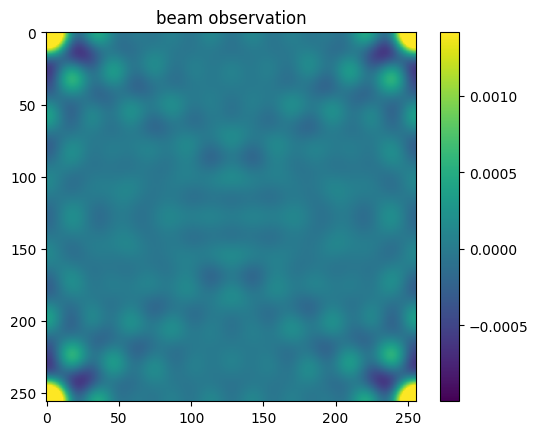

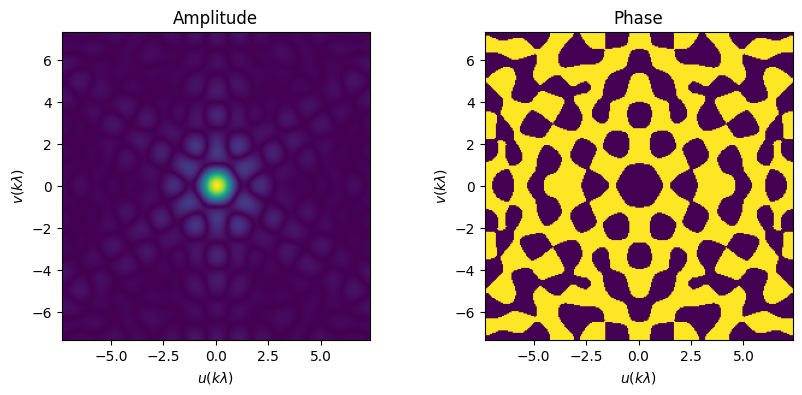

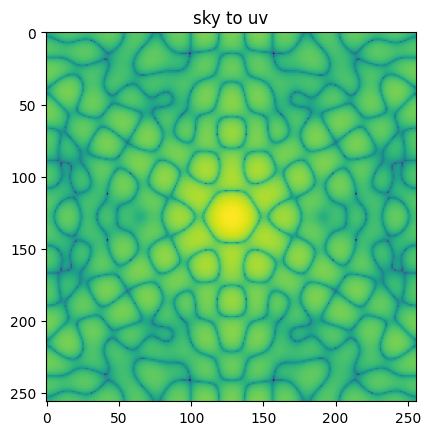

In [54]:

# Get the sky model image and the asociated field of view size
sky = dataset['image']
fov_size = np.sqrt(dataset['field_area_arcmin2'])/60.0

# Set up the antenna array, compute the baselines and the uv tracks
antena = antenna_utils.y_antenna_arr(n_antenna=30, r=10e3)
baselines = antenna_utils.get_baselines(antena)
track, _= antenna_utils.uv_track_multiband(baselines)

# Perform the observation
obs, dirty_beam = imaging_utils.simulate_dirty_observation(sky, track, fov_size)

plot_utils.plot_sky(sky, title="sky model")

plot_utils.plot_beam(dirty_beam)
plt.title('beam observation')

plot_utils.plot_sky_uv(dirty_beam, fov_size=(1.0, 1.0))
plt.title('sky to uv')

plt.imshow(np.log(np.abs(dirty_beam)))


(0.0, 0.5)

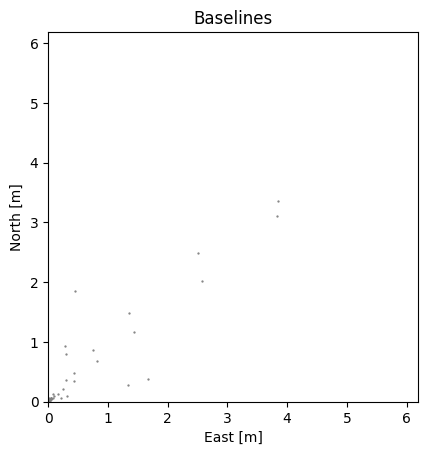

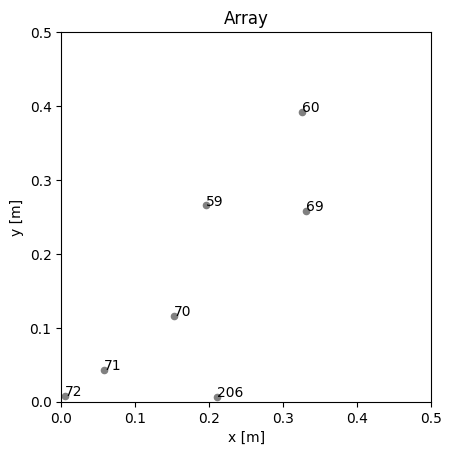

In [40]:
plot_utils.plot_baselines(sky, ENU=True)
plot_utils.plot_antenna_arr(sky)
plt.xlim(0,0.5)
plt.ylim(0,0.5)


In [28]:
import argosim
print(dir(argosim.imaging_utils)) 



['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add_noise_uv', 'compute_visibilities_grid', 'grid_uv_samples', 'local_seed', 'np', 'rnd', 'simulate_dirty_observation', 'sky2uv', 'uv2sky']


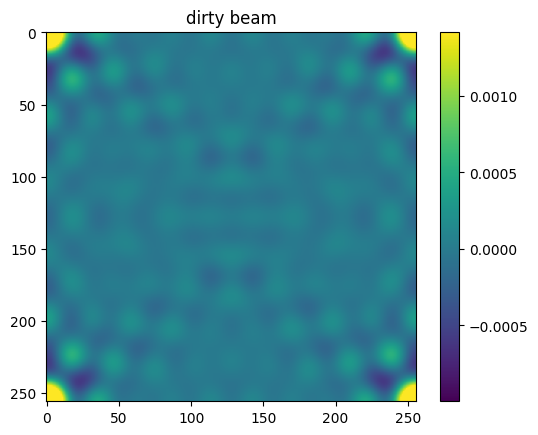

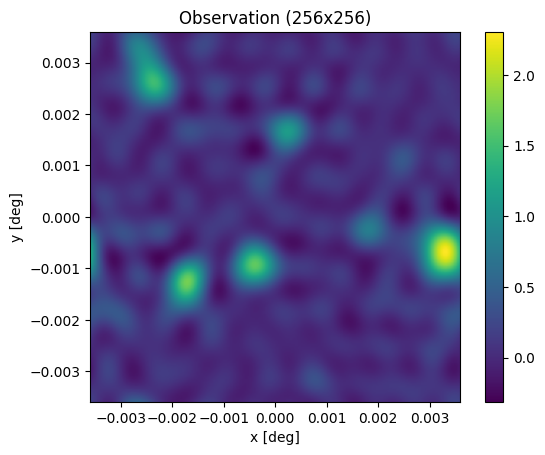

In [49]:
fov_size = (fov_size, fov_size)  

# Plot the dirty beam
argosim.plot_utils.plot_beam(dirty_beam)
plt.title('dirty beam')

# Plot the observation
argosim.plot_utils.plot_sky(obs, fov_size=fov_size, title="Observation")


Check the source code of the function `simulate_dirty_observation`. What does it do? And which other functions from the `imaging_utils` module does it use?

...

- simulate_dirty_observation simulates a radio observation of the given sky model, using sample points in UV space. It applies Gaussian noise and can handle multi-frequency observations

- imaging_utils :

sky2uv(sky): to transform the sky image into UV space

compute_visibilities_grid(): to calculate visibilities in UV space

uv2sky(): to reconstruct the image from UV space


In the source code, what does `vis` stand for? Explain...

...

vis is an abbreviation for visibilities. These are the measurements obtained in UV space, which correspond to the Fourier transform of the sky observed by the interferometer.